### Домашнее задание «Элементарные методы анализа временных рядов»

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

В ходе лекции применение моделей рассматривалось на примере данных о вооруженных ограблениях в Бостоне. Я возьму временной ряд - данные о колебаниях индекса Доу-Джонса. Это ряд без явной сезонности, но его можно разбить на 2 участка, где прослеживается монотонный тренд, вначале возрастающий, затем убывающий.

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from scipy.stats import boxcox

import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
ts = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")['Close']

Вспомогательные функции

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.legend()
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

#### Стационарный и нестационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


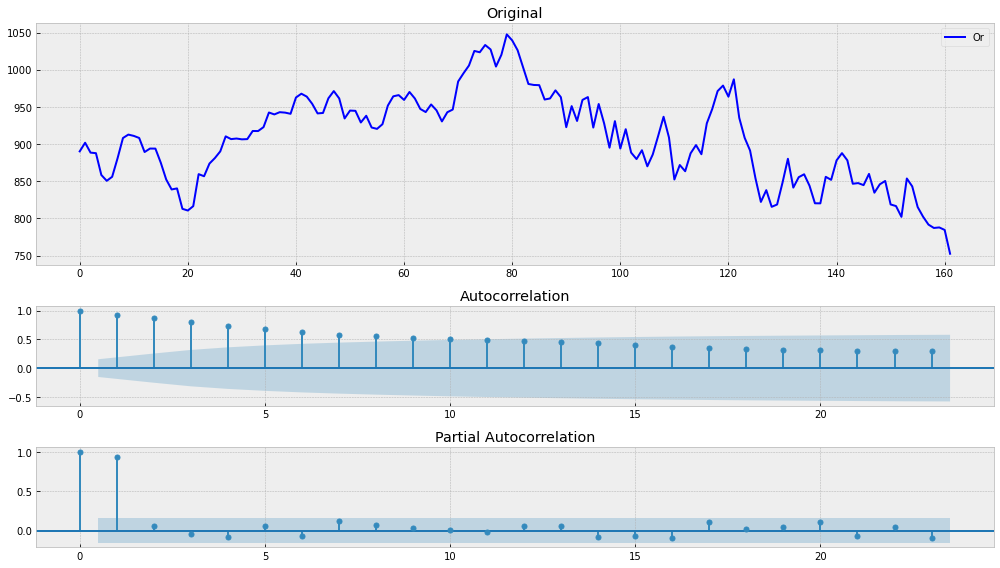

In [6]:
tsplot(ts)

Исходный ряд очевидно не является стационарным. Приведем его к такому виду

In [78]:
ts_stat = boxcox(ts, 0)
ts_stat = np.diff(ts_stat, 1)


Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


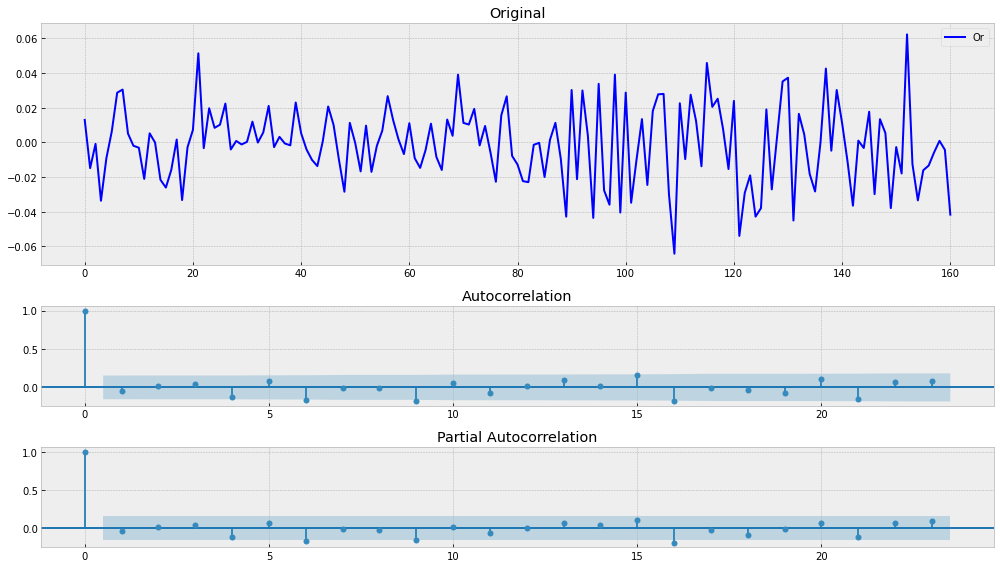

In [79]:
tsplot(ts_stat)

Теперь будем исследовать оба ряда с помощью МА моделей

#### Скользящее среднее

In [9]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

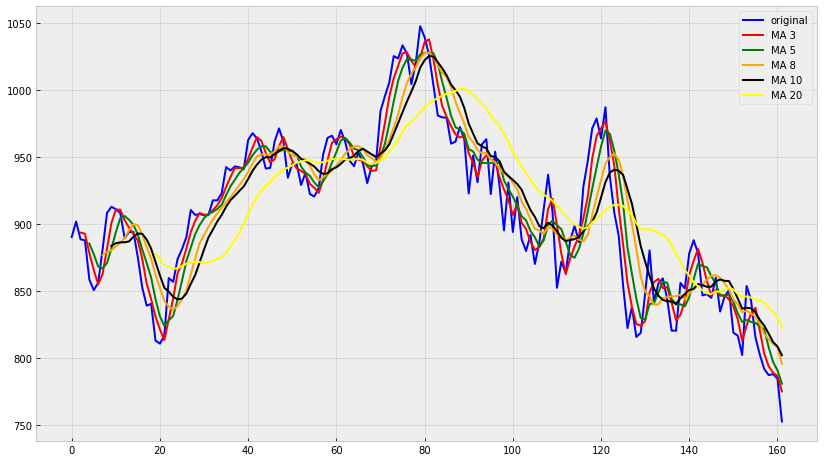

In [10]:
# на исходном ряде
windows = [3, 5, 8, 10, 20]
color_list = ['red', 'green', 'orange', 'black', 'yellow']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    for i, window in enumerate(windows):
        ser = moving_average(ts, window)
        plt.plot(ser, color=color_list[i], label='MA {}'.format(window))
    plt.legend()

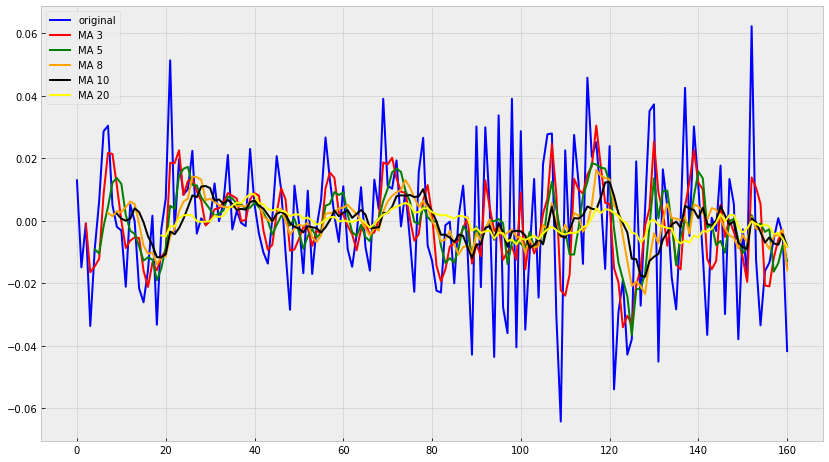

In [11]:
# на стационарном ряде
windows = [3, 5, 8, 10, 20]
color_list = ['red', 'green', 'orange', 'black', 'yellow']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts_stat, color='blue',label='original')
    for i, window in enumerate(windows):
        ser = moving_average(ts_stat, window)
        plt.plot(ser, color=color_list[i], label='MA {}'.format(window))
    plt.legend()

Ожидаемо наиболее близко к исходному ряду приближение скользящим средним с наименьшим окном

#### Взвешенное скользящее среднее

In [12]:
def weighted_moving_average(series,  weights):
    n = len(weights)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

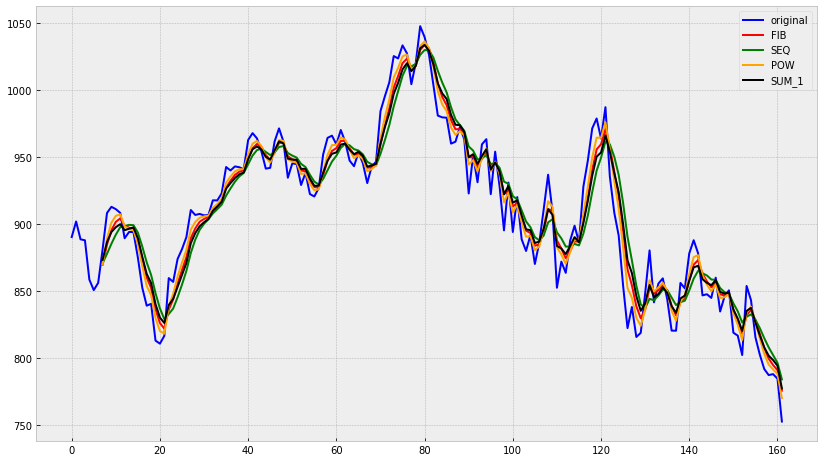

In [13]:
weight_dict = {
    'FIB': [1, 1, 2, 3, 5, 8, 13, 21],
    'SEQ': [1, 2, 3, 4, 5, 6, 7, 8],
    'POW': [1, 2, 4, 8, 16, 32, 64, 128],
    'SUM_1': [0.03, 0.05, 0.06, 0.07, 0.09, 0.1, 0.2, 0.4] #сумма коэффициентов = 1
}

color_list = ['red', 'green', 'orange', 'black']

# на исходном ряде
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    for i, weights in enumerate(weight_dict.items()):
        wma = weighted_moving_average(ts, weights[1])
        plt.plot(wma, color=color_list[i], label=weights[0])

    plt.legend()

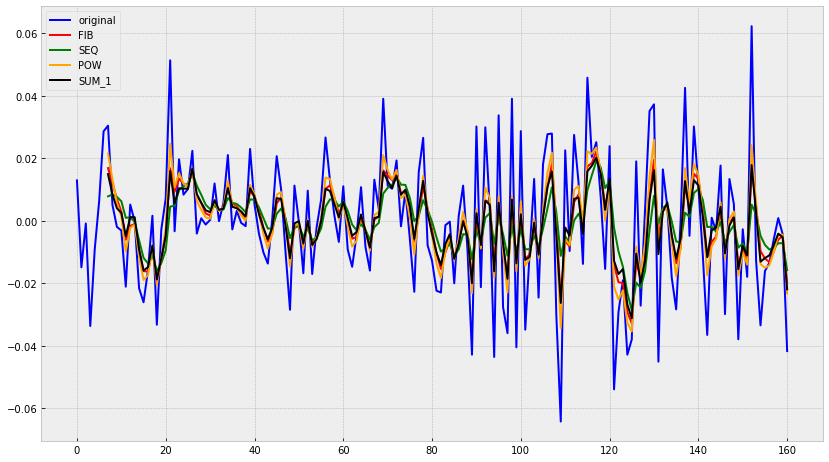

In [14]:
# на стационарном ряде
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts_stat, color='blue',label='original')
    for i, weights in enumerate(weight_dict.items()):
        wma = weighted_moving_average(ts_stat, weights[1])
        plt.plot(wma, color=color_list[i], label=weights[0])

    plt.legend()

Результаты в целом достаточно похожи между собой, однако веса, выбранные в соответствии со степенями 2, дают наилучшее приближение  

#### Экспоненциальное сглаживание

In [15]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

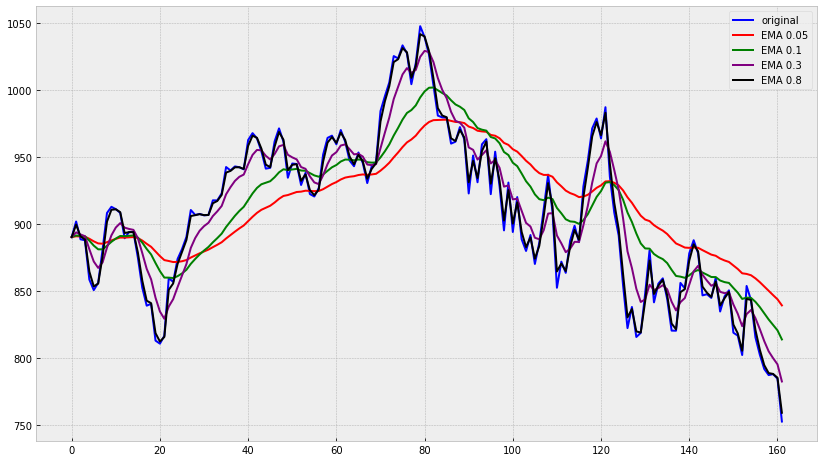

In [16]:
# на исходном ряде
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(ts, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

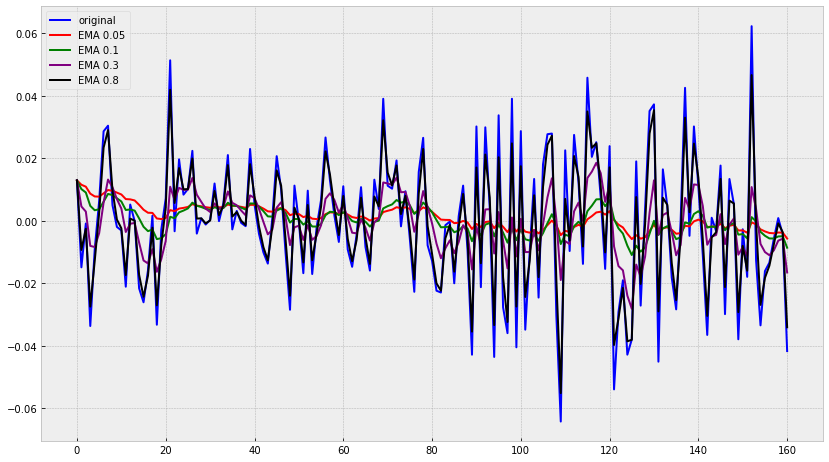

In [17]:
# на стационраном ряде
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts_stat, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(ts_stat, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

При значении alpha близким к 1 исходный ряд приближен довольно-таки неплохо. На стационарном ряде осталось больше пиковых значений, к которым график приближения не смог подобраться

#### Двойное экспоненциальное сглаживание

In [18]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [19]:
def plot_dema(ts, alpha, beta):
    dema = double_ema(ts, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ts, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='3', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

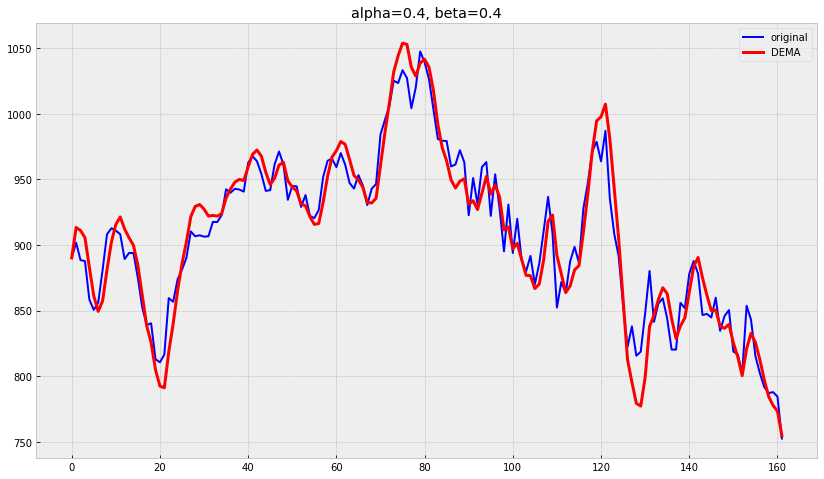

In [83]:
# на исходном ряде, с произвольными коэффициентами 
plot_dema(ts, 0.4, 0.4)

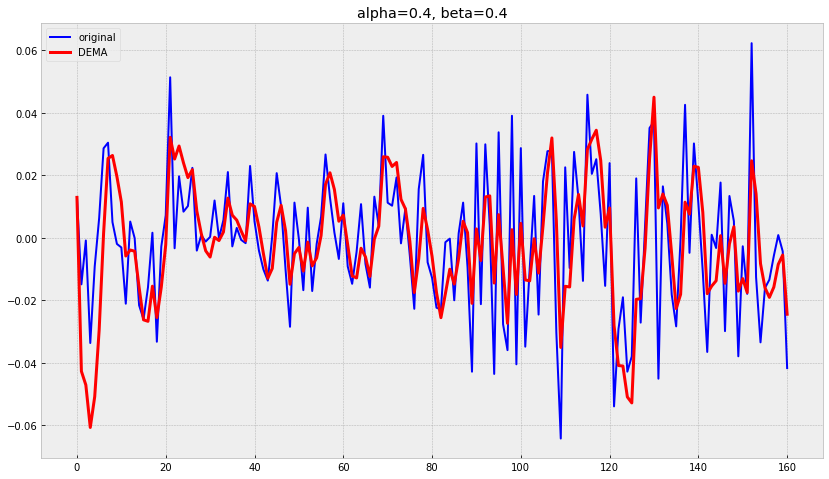

In [84]:
# на стационарном ряде, с произвольными коэффициентами 
plot_dema(ts_stat, 0.4, 0.4)

Попробуем подобрать коэффициенты alpha и beta с помощью алгоритмов оптимизации 

In [22]:
len(ts)

162

In [47]:
train, test, val = ts[:110], ts[110:140], ts[140:]

In [48]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [49]:
def mse_dema(X):
    alpha, beta = X
    result = double_ema(train, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [50]:
opt = minimize(mse_dema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [51]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 6268.255380764124
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00236469, -0.00190994])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 18
   status: 0
  success: True
        x: array([0.93309975, 0.35699636])


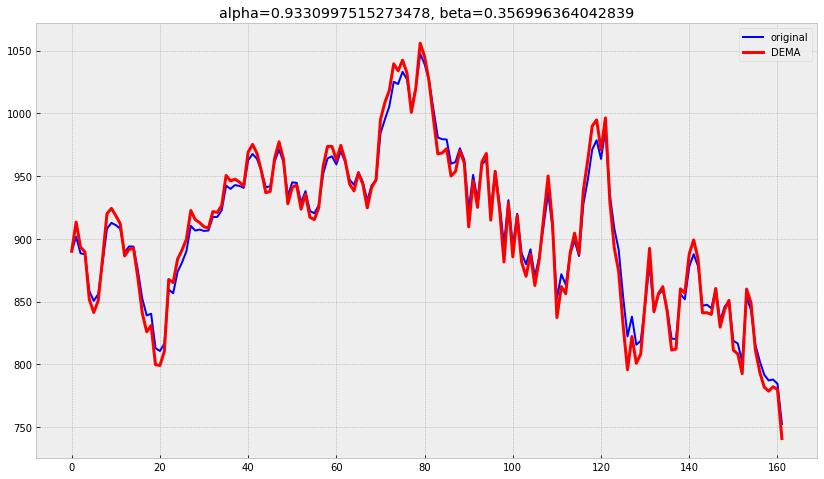

In [52]:
plot_dema(ts, alpha_opt, beta_opt)

In [53]:
train_st, test_st, val_st = ts_stat[:110], ts_stat[110:140], ts_stat[140:]

In [54]:
def mse_dema_stat(X):
    alpha, beta = X
    result = double_ema(train_st, alpha, beta)
    predictions = result[-len(test_st):]
    error = mean_squared_error(predictions, test_st)
    return error

In [55]:
opt = minimize(mse_dema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt, beta_opt = opt.x

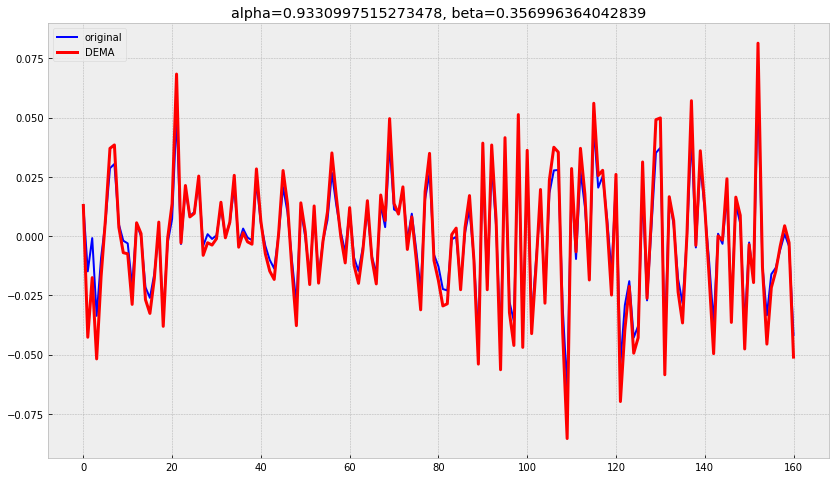

In [56]:
plot_dema(ts_stat, alpha_opt, beta_opt)

Видим, что с новыми коэффициентами графики приближения и исходного, и стационарного ряда достаточно близки к графикам самих  рядов. 

#### Метод Хольта-Винтерса

Этот метод не должен показать каких-то выдающихся результатов, поскольку в наших рядах отсутствует сезонная компонента. Но для полноты картины рассмотрим и тройное экспоненциальное сглаживание наравне с остальными.

In [57]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [58]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [59]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [60]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='3', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

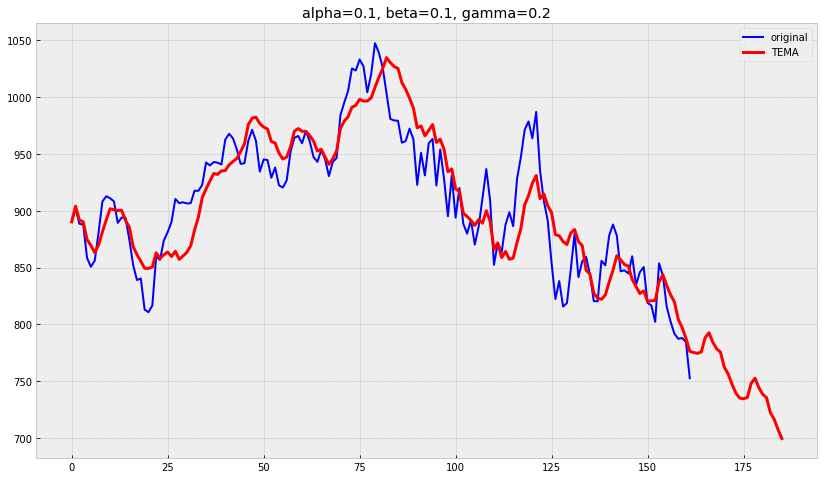

In [61]:
plot_tema(0.1, 0.1, 0.2, ts, ts)

In [62]:
def mse_tema(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [63]:
opt = minimize(mse_tema, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [64]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 2248.2056171845197
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.03638106e+03,  0.00000000e+00, -4.54747351e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 64
      nit: 11
   status: 0
  success: True
        x: array([0.        , 0.        , 0.00443056])


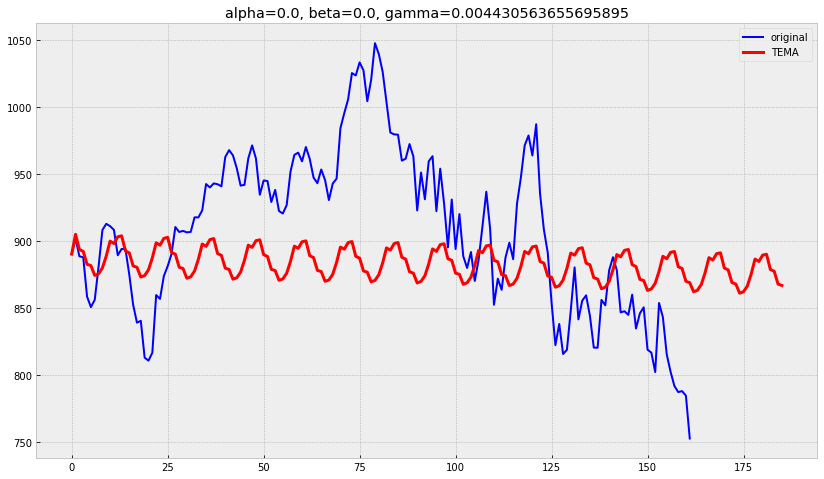

In [65]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ts, ts)

In [66]:
def mse_tema_stat(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train_st, 12, alpha, beta, gamma, len(test_st))
    predictions = result[-len(test_st):]
    error = mean_squared_error(predictions, test_st)
    return error

In [67]:
opt = minimize(mse_tema_stat, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [68]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.0007067621066223585
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.59530980e-04, -1.16806304e-05, -5.50535095e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 240
      nit: 44
   status: 0
  success: True
        x: array([0.00179713, 0.10211997, 0.00826966])


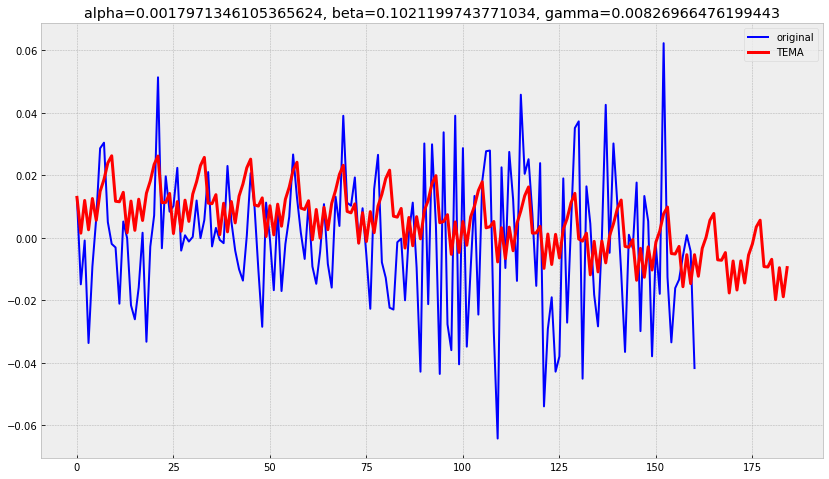

In [69]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ts_stat, ts_stat)

Как и ожидалось, метод Хольта-Винтерса пытается построить что-то с конкретно выраженной сезонностью, а это совсем не близко нашим данным.

Как итог, наиболее правдоподобную картину приближения я увидела при использовании метода двойного экспоненциального сглаживания. 

In [72]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

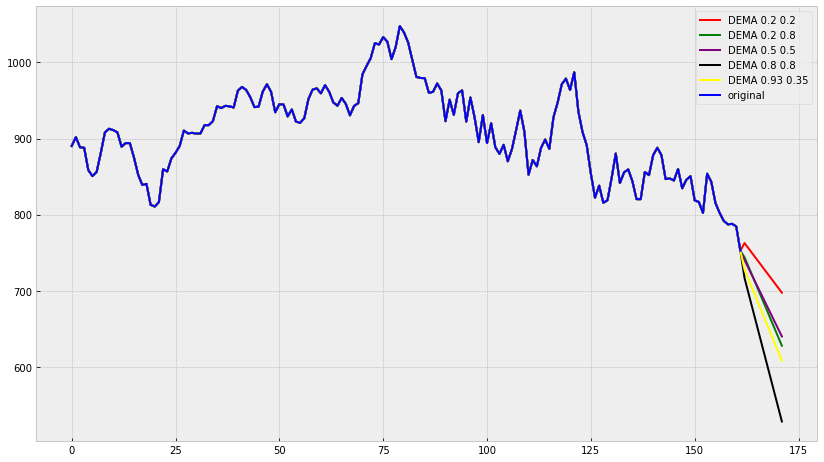

In [85]:
alphas = [0.2,0.2,0.5,0.8,0.93]
bettas = [0.2,0.8,0.5,0.8,0.35]
colors = ['red', 'green', 'purple', 'black', 'yellow']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(ts, alphas[i], bettas[i], 10)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(ts, color='blue',label='original')
    plt.legend()

Однако как прогнозная модель DEMA вряд ли даст достоверные предсказания. Она поймала убывающий тренд, и последующие значения ряда в предсказании будут падать. В том числе и для коэффициентов, подобранных после оптимизации (желтые на графике). 